## Baseline checks

Just checking everything works as it should

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
import json


centralized_training_loss = glob.glob(f"../results/periodic/centralized_training/**/loss_per_epoch.csv", recursive=True)
centralized_training_loss = centralized_training_loss[0]
# aggregation = "FedODE"
# fed_subfolder = f"{aggregation}/2_rounds"


# fed_subfolder_fedode = f"{aggregation}/2_rounds"
# fed_subfolder_fedavg = f"{aggregation}/2_rounds"


### Check centralized training

Text(0.5, 1.0, 'Centralized Training MSE')

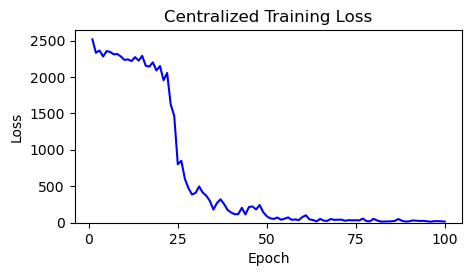

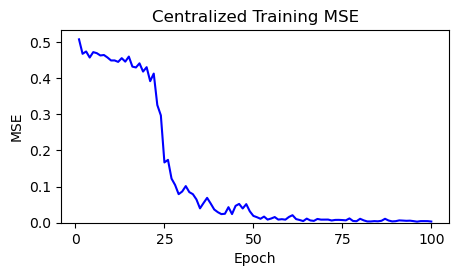

In [17]:
#read in the csv file
df_centralized_training_loss = pd.read_csv(centralized_training_loss)
df_centralized_training_loss['epoch'] = df_centralized_training_loss['epoch'] + 1

#plot the training loss
plt.figure(figsize=(5, 2.5))
plt.plot(df_centralized_training_loss['epoch'], df_centralized_training_loss['loss'], label='Centralized Training Loss', color='blue')
# add 1 to the epoch 
plt.ylim(bottom=0)
# x axis is discrete
plt.xticks(df_centralized_training_loss['epoch'])
# plot only every 50th epoch
max_epoch = df_centralized_training_loss['epoch'].max()
plt.xticks(np.arange(0, max_epoch+1, 25))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Centralized Training Loss')


plt.figure(figsize=(5, 2.5))
plt.plot(df_centralized_training_loss['epoch'], df_centralized_training_loss['mse'], label='Centralized Training Loss', color='blue')
plt.ylim(bottom=0)
# x axis is discrete
plt.xticks(df_centralized_training_loss['epoch'])
plt.xticks(np.arange(0, max_epoch+2, 25))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Centralized Training MSE')


## Federated 

#### Check weight divergence

In [31]:
# get FedAvg and check it is learning
fed_avg = glob.glob(f"../results/periodic/**/FedAvg/**/federated_outputs", recursive=True)
fed_avg = fed_avg[0]

In [37]:
# per client load the weigths
cn = 0

results = glob.glob(f"{fed_avg}/results_{cn}.json", recursive=True)[0]
with open(results, "r") as f:
    data = json.load(f)

In [44]:
data["client_train"][0]["weights"]

'weights_509843.pt'

In [45]:
# extract rounds and weights and put in a dataframe
rounds = []
weights = []
for i in range(len(data["client_train"])):
    rounds.append(data["client_train"][i]["round"])
    weights.append(data["client_train"][i]["weights"])
df_fedavg = pd.DataFrame({"round": rounds, "weights": weights})

In [58]:
df_fedavg

,round,weights
0,0,weights_509843.pt
1,1,weights_224537.pt


In [ ]:
df_fedavg
# now read in the weights 
# the path is .. /weights/weights_0.pth
def load_weigths(round):
    w_name = df_fedavg["weights"][0]
    w_file = glob.glob(f"{fed_avg}/../{w_name}", recursive=True)
    return torch.load(w_file[0])




/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_14182/91580816.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  w0 = torch.load(w0_file[0])


[array([[-0.24335806,  0.586268  ,  0.09524707, ..., -0.04581514,
         -0.15264665, -0.33384565],
        [-0.27292797,  0.3300757 ,  0.2800161 , ...,  0.30838886,
          0.22566797,  0.21791132],
        [-0.01528424, -0.06688975, -0.00462198, ..., -0.03208536,
          0.24232239,  0.5936107 ],
        ...,
        [-0.4636882 ,  0.4207984 ,  0.40416816, ...,  0.1380988 ,
         -0.22407943, -0.16629641],
        [-0.30254593,  0.2370311 ,  0.40459144, ...,  0.10433337,
         -0.02031516, -0.14230338],
        [ 0.37104455, -0.5838371 , -0.57579315, ..., -0.13536704,
          0.10491477, -0.10853539]], dtype=float32),
 array([-0.16668811,  0.16731618,  0.39387593, -0.02771915,  0.16939783,
         0.16914436, -0.03579544,  0.17395538, -0.03156365,  0.1833336 ,
         0.3839471 ,  0.16304545, -0.38367665, -0.18512604,  0.03586955,
        -0.38430133,  0.23896116,  0.18121247,  0.17684066,  0.16813271,
        -0.16825643,  0.18414128, -0.1642789 , -0.16003536,  0.180

In [ ]:

# Now load the federated learning loss
federated_training_loss = fed_avg + "/results.json"
with open(federated_training_loss, 'r') as f:
    data = json.load(f)

# Plot centralized evaluate
df_centralized_evaluate = pd.DataFrame(data['centralized_evaluate'])
df_federated_evaluate = pd.DataFrame(data['federated_evaluate'])

# Join the two dataframes on the round
df_centralized_evaluate['round'] = df_centralized_evaluate['round'].astype(int)
df_federated_evaluate['round'] = df_federated_evaluate['round'].astype(int)

# join the two dataframes on the round
df = pd.merge(df_centralized_evaluate, df_federated_evaluate, on='round')
# now plot the data
plt.figure(figsize=(5, 2.5))
plt.plot(df['round'], df['centralized_loss'], label='Centralized Test Loss', color='blue')
plt.plot(df['round'], df['federated_evaluate_loss'], label='Federated Test Loss', color='orange')
# log scale

# add legend on the outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(bottom=0)
# x axis is discrete
plt.xticks(df['round'])

FileNotFoundError: [Errno 2] No such file or directory: './results.json'

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_3206/870365384.py:46: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


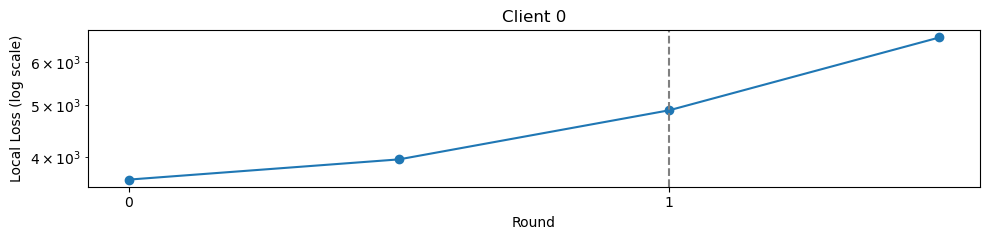

/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_3206/870365384.py:46: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


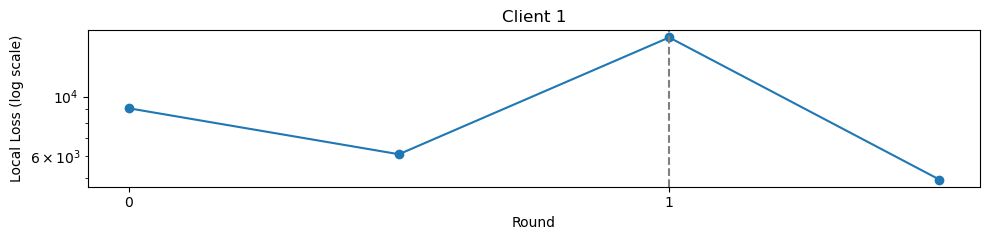

In [63]:
cn = 0

def plot_client_loss(cn):

    # Load JSON file
    with open(f"../results/periodic/federated_training/{fed_subfolder}/federated_outputs/results_{cn}.json", "r") as f:
        data = json.load(f)


    # Extract loss values, rounds, and epochs
    loss_values = []
    rounds = []
    epochs = []

    epoch_count = 0  # To keep track of epochs

    for entry in data["client_train"]:
        round_number = entry["round"]
        for loss in entry["loss"]:
            rounds.append(round_number)
            loss_values.append(loss)
            epochs.append(epoch_count)
            epoch_count += 1

    # make it smaller 
    plt.figure(figsize=(10, 2.5))
    # Plot loss values sequentially across rounds and epochs
    plt.plot(epochs, loss_values, marker='o', label="Loss across epochs")


    # Add vertical lines for each round number
    for round_number in set(rounds):
        round_epochs = [i for i, r in enumerate(rounds) if r == round_number]
        if round_epochs:
            # Place a vertical line at the first epoch of each round
            # if it is not the first round
            if round_number != 0:
                plt.axvline(x=round_epochs[0], color='grey', linestyle='--', label=f"Round {round_number}")

    # Customize x-axis ticks to represent rounds
    xticks = [i for i, round_number in enumerate(rounds) if i == 0 or rounds[i] != rounds[i-1]]
    plt.xticks(xticks, [rounds[i] for i in xticks])
    # log scale y 
    plt.yscale('log')

    plt.ylim(bottom=0)
    plt.xlabel("Round")
    plt.ylabel("Local Loss (log scale)")
    plt.title(f"Client {cn}")
    plt.tight_layout()
    plt.show()

plot_client_loss(0)
plot_client_loss(1)

([<matplotlib.axis.XTick at 0x30aec3b00>,
 [Text(1, 0, '1'), Text(2, 0, '2')])

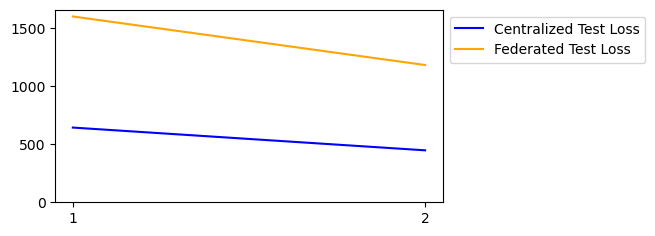

Text(0.5, 1.0, 'Test MSE')

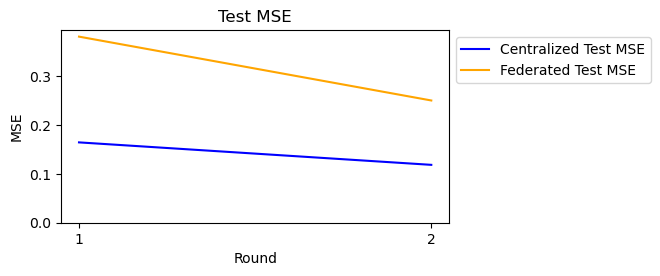

In [65]:
# same as above with mse
plt.figure(figsize=(5, 2.5))
plt.plot(df['round'], df['centralized_accuracy'], label='Centralized Test MSE', color='blue')
plt.plot(df['round'], df['federated_evaluate_accuracy'], label='Federated Test MSE', color='orange')
# add legend on the outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(bottom=0)
# x axis is discrete
plt.xticks(df['round'])
# add x and y labels
plt.xlabel('Round')
plt.ylabel('MSE')
plt.title('Test MSE')

## Use the produced model to plot the output

In [ ]:


# Now load the federated learning loss
fedode = f"../results/periodic/federated_training/{fed_subfolder_fedode}/federated_outputs/results.json"
fedavg = f"../results/periodic/federated_training/{fed_subfolder_fedavg}/federated_outputs/results.json"

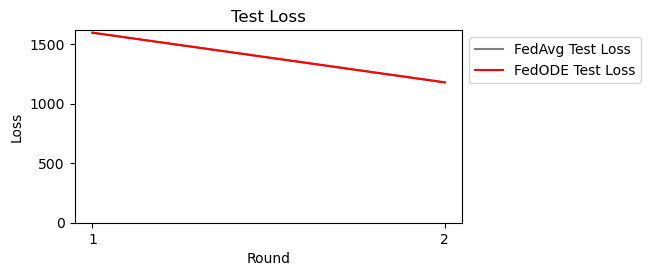

In [67]:
# plot loss of both fedode and fedavg
with open(fedavg, 'r') as f:
    data_fedavg = json.load(f)
with open(fedode, 'r') as f:
    data_fedode = json.load(f)

data_fedavg_df = pd.DataFrame(data_fedavg['federated_evaluate'])
data_fedode_df = pd.DataFrame(data_fedode['federated_evaluate'])
# join the two dataframes on the round
data_fedavg_df['round'] = data_fedavg_df['round'].astype(int)
data_fedode_df['round'] = data_fedode_df['round'].astype(int)
df_fedavg_fedode = pd.merge(data_fedavg_df, data_fedode_df, on='round')
# now plot the data
plt.figure(figsize=(5, 2.5))
plt.plot(df_fedavg_fedode['round'], df_fedavg_fedode['federated_evaluate_loss_x'], label='FedAvg Test Loss', color='grey')  
plt.plot(df_fedavg_fedode['round'], df_fedavg_fedode['federated_evaluate_loss_y'], label='FedODE Test Loss', color='red')
# add legend on the outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(bottom=0)
# x axis is discrete
plt.xticks(df_fedavg_fedode['round'])
# add x and y labels
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show()


In [68]:
data_fedavg_df

,round,federated_evaluate_loss,federated_evaluate_accuracy
0,1,1597.678711,0.381641
1,2,1180.272257,0.250699


In [69]:
data_fedode_df

,round,federated_evaluate_loss,federated_evaluate_accuracy
0,1,1597.678711,0.381641
1,2,1180.272257,0.250699
